In [3]:
#Standard Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Image processing
# from scipy import ndimage
import cv2
from skimage import exposure, data, img_as_float
from skimage.feature import hog

#Remove Background
# from rembg import remove

#PCA & TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Models
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Hyperparameter Search
import keras_tuner as kt
from sklearn.model_selection import GridSearchCV

#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

#Resnet Feature Extraction
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input



In [4]:
#Set directory to train data
TRAIN_DIR = "../BloodCell/data/train"
VAL_DIR = "../BloodCell/data/val_no_background"
TEST_DIR = "../BloodCell/data/test_no_background"

### Examples of Original Images

In [4]:
def display_orig_images(folder_path):

    #Load images
    img_list = []
    for i in range(len(os.listdir(folder_path))):
        img_path =  os.listdir(folder_path)[i]
        img = plt.imread(os.path.join(folder_path, img_path))
        img_list.append(img)
    
    # Plot images
    image_labels = ['Platelet', 'Eosinophil', 'Basophil', 'Lymphocyte', 'IG', 'Monocyte', 'Neutrophil', 'Erythroblast']
    fig = plt.figure(figsize=(20,9))

    nrows=2
    ncols=4
    for i in range(1, nrows*ncols+1):

        img = img_list[i-1]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_labels[i-1])

    plt.show()

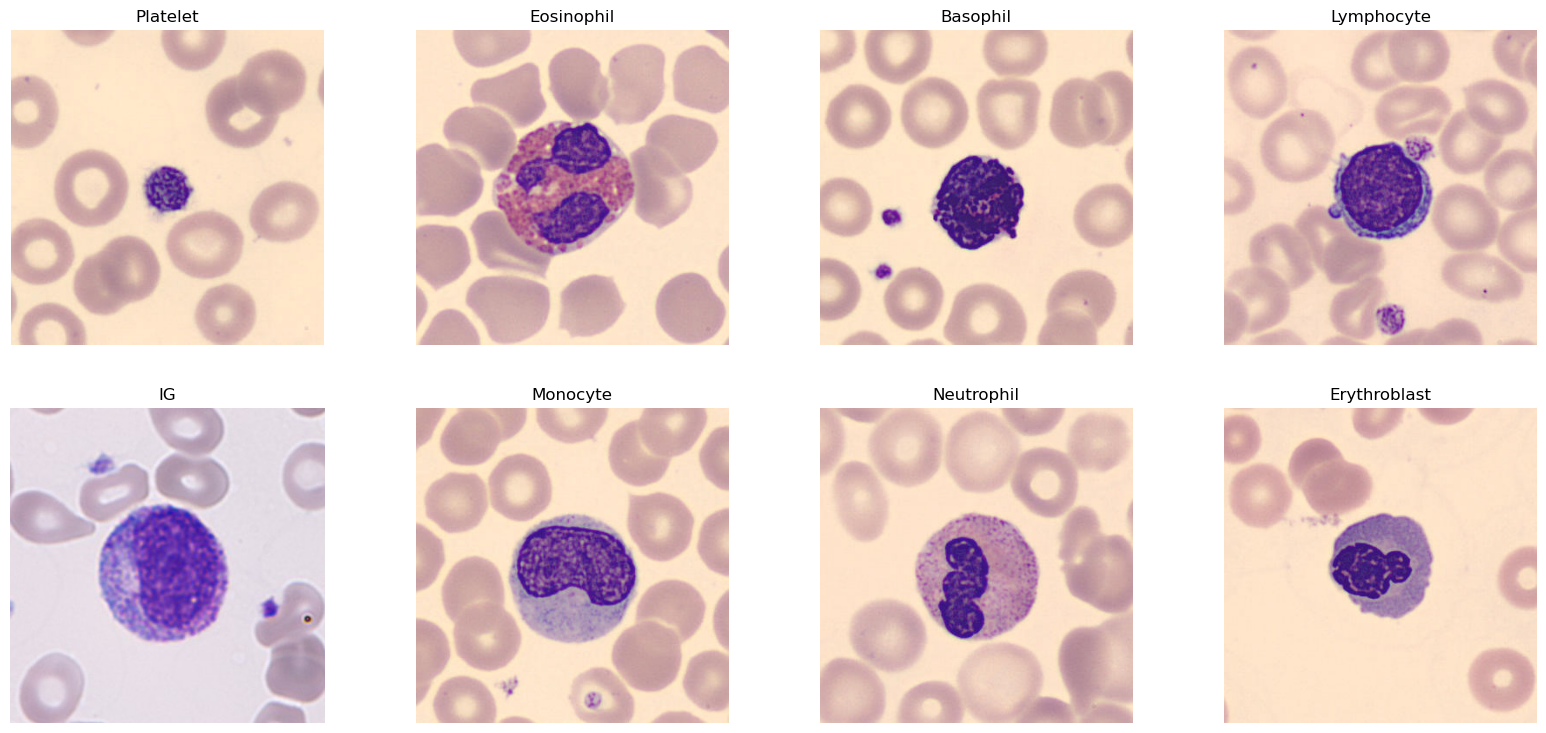

In [5]:
display_orig_images('/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/original_images_examples')

In [8]:
def remove_background(folder_path):
    """
    Remove background from each image using rembg library
    """

    #Load images
    img_list = []
    for i in range(len(os.listdir(folder_path))):
        img_path =  os.listdir(folder_path)[i]
        img = plt.imread(os.path.join(folder_path, img_path))
        img_list.append(img)

    out_imgs = []
    for i in range(len(img_list)):

        img = img_list[i]
        out_img = remove(img)
        #Convert back to grayscale
        out_img= cv2.cvtColor(out_img, cv2.COLOR_BGR2GRAY)
        out_imgs.append(out_img)
        
    # Plot images
    image_labels = ['Original Platelet', 'Original Eosinophil', 'Original Basophil', 'Original Lymphocyte', 'Original IG', 
                    'Original Monocyte', 'Original Neutrophil', 'Original Erythroblast', 'Rembg Platelet', 'Rembg Eosinophil', 
                    'Rembg Basophil', 'Rembg Lymphocyte', 'Rembg IG', 'Rembg Monocyte', 'Rembg Neutrophil', 'Rembg Erythroblast']
    fig = plt.figure(figsize=(40,9))

    nrows=2
    ncols=8
    for i in range(1, nrows*ncols+1):

        img_list.extend(out_imgs)

        img = img_list[i-1]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(image_labels[i-1])

    plt.show()

In [ ]:
remove_background('/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/original_images_examples')

### Functions for Image Loading, Processing, & Display

In [10]:
def load_example_images():
    """
    Load 1st image from each class folder 
    """
    folder_path: str = os.path.join(TRAIN_DIR)
    folders: list[str] = os.listdir(folder_path)
    imgs: np.ndarray = np.ndarray((360, 360, len(folders)))
    for f in folders:
        f_path = os.path.join(folder_path, f)
        img_path =  os.listdir(f_path)[0]
        # print(img_path)
        imgs[:,:, folders.index(f)] = plt.imread(os.path.join(f_path, img_path))

    return imgs

In [11]:
def load_images_by_class(data_group: str, class_name: str):
    """
    Load image set into a np matrix
    """
    folder_path: str = os.path.join(DIR, data_group, class_name)
    img_list: list[str] = os.listdir(folder_path)
    imgs = np.ndarray((360,360,len(img_list)))
    for i in range(len(img_list)):
        imgs[:,:,i] = plt.imread(os.path.join(folder_path, img_list[i]))

    return imgs

In [12]:
def crop_imgs(imgs, desired_img_size):
    '''
    Crop images further to remove blank space (assuming square images)
    '''
    cropped_imgs = np.ndarray((desired_img_size, desired_img_size, imgs.shape[2]))

    for i in range(imgs.shape[2]):
        img = imgs[:,:,i]
        img_size = int(img.shape[0])
        crop_size = int((img_size - desired_img_size)/2)

        #Crop rows and columns of image
        img = img[crop_size:img_size-crop_size, crop_size:img_size-crop_size]
        cropped_imgs[:,:,i] = img


    return cropped_imgs

In [14]:
def guassian_blur(imgs, filter_size):
    '''
    Apply guassian filter to images to address jpeg artifacts
    '''

    for i in range(imgs.shape[2]):
        img = imgs[:,:,i]

        #Apply 3x3 gauassian filter
        img = cv2.GaussianBlur(img, filter_size, 0)

    return imgs

In [15]:
def normalize_pixel_vals(imgs: np.array):
    """
    Normalize 0-255 scale to 0-1 scale for an array or matrix
    """
    imgs = (imgs/255).astype('float64')
    return imgs

In [16]:
def display_images(imgs, title):
    fig = plt.figure(figsize=(20,8))

    nrows=int(imgs.shape[2]/4)
    ncols=4
    for i in range(1, nrows*ncols+1):

        img = imgs[:,:,i-1]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(img, cmap="gray", vmin=0, vmax=1)
        plt.axis('off')

    plt.suptitle(f'{title}')
    plt.show()

In [17]:
def hog_features(imgs):

    imgs = normalize_pixel_vals(imgs)

    f_matrix = np.ndarray((imgs.shape[2], 18225))
    h_matrix = np.ndarray(imgs.shape)


    for i in range(imgs.shape[2]):

        img = imgs[:,:,i]
        f, h = hog(img, orientations=9, pixels_per_cell=(10,10), visualize=True, feature_vector=True)
        f_matrix[i,:] = f
        h_matrix[:,:,i] = h

    return f_matrix, h_matrix

In [18]:
def display_hog(imgs, title):
    """
    Display hog images.
    """
    fig = plt.figure(figsize=(20,20))

    nrows=int(imgs.shape[2]/2)
    ncols=2

    for i in range(1, nrows*ncols+1):

        img = imgs[:,:,i-1]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(10*img, cmap='gray', vmin=0, vmax=0.5)

    plt.suptitle(f'{title}')
    plt.show()  

### Functions for PCA & tSNE

In [12]:
def run_pca(feat_vector, n_components):

    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(feat_vector)
    X_pca = pca.transform(feat_vector)

    return pca, X_pca

In [4]:
def run_tsne(feat_vector, n_components, perplexity, learning_rate):

    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, random_state=0)
    X_tsne = tsne.fit_transform(feat_vector)

    return X_tsne

In [5]:
def plot_classes(X, y, ax, title):
    # color code each cluster (person ID)
    colormap = plt.cm.tab20
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

    # Project the features into 2 dimensions
    scatter_handles = []
    for k in range(len(np.unique(y))):
        scatter_handle = ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k], label=os.listdir(TRAIN_DIR)[k].title())
        scatter_handles.append(scatter_handle)

    # Set title
    ax.set_title(title)

    # Add legend
    ax.legend(handles=scatter_handles, loc='upper left',  bbox_to_anchor=(1.05, 1))

    #Add axes labels
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')

### Get Image Labels

In [6]:
def get_img_labels(source_dir):

    #Define empty label list and start class label at zero
    labels = []
    class_label = 0

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        # Check if it's a directory
        if os.path.isdir(class_path):

            #calculate the number of image samples within each class
            qty_class_samples = len(os.listdir(class_path))

            #Add class label to label list for all image samples within each class
            labels.extend([class_label]*qty_class_samples)

            #Increment class label
            class_label += 1
        
        print(f"Labels extracted for all images in class {class_name}.")

    
    #Convert to np array
    labels = np.array(labels)

    return labels

In [7]:
train_labels = get_img_labels(TRAIN_DIR)
np.save('feat_vectors/train_labels', train_labels)
train_labels.shape

Labels extracted for all images in class platelet.
Labels extracted for all images in class monocyte.
Labels extracted for all images in class ig.
Labels extracted for all images in class erythroblast.
Labels extracted for all images in class lymphocyte.
Labels extracted for all images in class basophil.
Labels extracted for all images in class eosinophil.
Labels extracted for all images in class neutrophil.


(20376,)

In [8]:
val_labels = get_img_labels(VAL_DIR)
np.save('feat_vectors/val_labels', val_labels)
val_labels.shape

Labels extracted for all images in class platelet.
Labels extracted for all images in class monocyte.
Labels extracted for all images in class ig.
Labels extracted for all images in class erythroblast.
Labels extracted for all images in class lymphocyte.
Labels extracted for all images in class basophil.
Labels extracted for all images in class eosinophil.
Labels extracted for all images in class neutrophil.


(1456,)

In [9]:
test_labels = get_img_labels(TEST_DIR)
np.save('feat_vectors/test_labels', test_labels)
test_labels.shape

Labels extracted for all images in class platelet.
Labels extracted for all images in class monocyte.
Labels extracted for all images in class ig.
Labels extracted for all images in class erythroblast.
Labels extracted for all images in class lymphocyte.
Labels extracted for all images in class basophil.
Labels extracted for all images in class eosinophil.
Labels extracted for all images in class neutrophil.


(1464,)

### Extract Features

In [14]:
########################################################################################################################
# Function to normalize pixel values to 0-1 scale
########################################################################################################################

def normalize_pixel_vals(imgs: np.array):
    """
    Normalize 0-255 scale to 0-1 scale for an array or matrix
    """
    imgs = (imgs/255).astype('float64')
    return imgs

In [83]:
########################################################################################################################
# Function to center/square crop an image to a desired pixel size
########################################################################################################################

def crop_img(img, desired_img_size):
    '''
    Center crop image further to remove blank space (assuming square images)
    '''

    img_size = int(img.shape[0])
    crop_size = int((img_size - desired_img_size)/2)

    #Crop rows and columns of image
    crop_img = img[crop_size:img_size-crop_size, crop_size:img_size-crop_size]


    return crop_img

In [16]:
########################################################################################################################
# Function to extract luminance feature vectors 
# Reads in image, normalizes pixel values, and extracts Luminance feat. vector based on number of desired bins and 
# range of values included in histogram (defaults between 0 and 1)
########################################################################################################################

def get_lum_feat_vectors(source_dir, bins, range=(0, 1.0)):
    # Iterate over all class directories in the source directory

    lum_feat_vectors = []
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        # Check if it's a directory
        if os.path.isdir(class_path):

            # Iterate over all image files in the class directory
            for filename in os.listdir(class_path):
                if filename.lower().endswith('.jpg'):
                    file_path = os.path.join(class_path, filename)
                    
                    # Read the image as grayscale
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                    #Normalize image values and flatten image
                    image = (normalize_pixel_vals(image)).flatten()

                    #Extract luminance histogram feature vector
                    lum_hist = np.histogram(image, bins=bins, range=range)[0]
                    lum_feat_vectors.append(lum_hist)


            print(f"Luminance histogram feature vector has been extracted for all images in class {class_name}.")
    
    #Convert to np array
    lum_feat_vectors = np.array(lum_feat_vectors)

    #Save feature vectors to np file
    np.save('feat_vectors/lum_feat_vectors', lum_feat_vectors)
    print("Luminance feature vector extraction complete for all classes.")

In [158]:
train_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/train'
val_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/val_no_background'
test_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/test_no_background'

#Set range (0, 1.0) to include black background
# get_lum_feat_vectors(source_dir=train_dir, bins=50, range=(0,1.0))
# get_lum_feat_vectors(source_dir=val_dir, bins=50, range=(0,1.0))
get_lum_feat_vectors(source_dir=test_dir, bins=50, range=(0,1.0))

Luminance histogram feature vector has been extracted for all images in class platelet.
Luminance histogram feature vector has been extracted for all images in class monocyte.
Luminance histogram feature vector has been extracted for all images in class ig.
Luminance histogram feature vector has been extracted for all images in class erythroblast.
Luminance histogram feature vector has been extracted for all images in class lymphocyte.
Luminance histogram feature vector has been extracted for all images in class basophil.
Luminance histogram feature vector has been extracted for all images in class eosinophil.
Luminance histogram feature vector has been extracted for all images in class neutrophil.
Luminance feature vector extraction complete for all classes.


In [17]:
########################################################################################################################
# Function to extract HOG feature vectors 
# Reads in image, normalizes pixel values, center crops image to 176x176 pixels, and extracts HOG feat. vector
########################################################################################################################

def get_hog_feat_vectors(source_dir):
    # Iterate over all class directories in the source directory

    f_vectors = []
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        # Check if it's a directory
        if os.path.isdir(class_path):

            # Iterate over all image files in the class directory
            for filename in os.listdir(class_path):
                if filename.lower().endswith('.jpg'):
                    file_path = os.path.join(class_path, filename)
                    # Read the image
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                    #Normalize image values between 0 and 1 and crop to 176x176
                    image = crop_img(normalize_pixel_vals(image), 176)

                    # f = hog(image, orientations=6, pixels_per_cell=(8,8), cells_per_block=(2,2), 
                    #         visualize=False, feature_vector=True)

                    # f = hog(image, orientations=4, pixels_per_cell=(10,10), 
                    #         visualize=False, feature_vector=True)

                    #Potentially update hog paramters to obtain more granularity (see commented out sections above)
                    f = hog(image, orientations=4, pixels_per_cell=(25,25), 
                             visualize=False, feature_vector=True)

                    
                    f_vectors.append(f)


            print(f"HOG feature vector has been extracted for all images in class {class_name}.")
    
    #Convert to np arrays
    f_vectors = np.array(f_vectors)

    #Save np arrays to compressed file
    np.savez_compressed('feat_vectors/hog_feat_vects_compressed', a=f_vectors)

    print("HOG feature vector extraction complete for all classes.")

In [159]:
train_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/train'
val_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/val_no_background'
test_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/test_no_background'

# get_hog_feat_vectors(source_dir=train_dir)
# get_hog_feat_vectors(source_dir=val_dir)
get_hog_feat_vectors(source_dir=test_dir)

HOG feature vector has been extracted for all images in class platelet.
HOG feature vector has been extracted for all images in class monocyte.
HOG feature vector has been extracted for all images in class ig.
HOG feature vector has been extracted for all images in class erythroblast.
HOG feature vector has been extracted for all images in class lymphocyte.
HOG feature vector has been extracted for all images in class basophil.
HOG feature vector has been extracted for all images in class eosinophil.
HOG feature vector has been extracted for all images in class neutrophil.
HOG feature vector extraction complete for all classes.


In [18]:
########################################################################################################################
# Extract ResNet50 Feature Vectors
########################################################################################################################

def get_resnet_features(source_dir):

    # Load the ResNet50 model pre-trained on ImageNet dataset without the fully connected layers (final output layer)
    #Pooling is set to average to apply global average pooling to the final layer to produce a 2D tensor output
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # Initialize an empty list to store the feature vectors
    res_feats = []

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

    # Check if it's a directory
        if os.path.isdir(class_path):

            # Iterate over all image files in the class directory
            for filename in os.listdir(class_path):
                if filename.lower().endswith('.jpg'):
                    file_path = os.path.join(class_path, filename)
  
                    # Load and crop image to 224x224
                    # img = image.load_img(file_path, target_size=(224, 224))
                    img = crop_img(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE), 224)

                    # Convert to np array and load as image with 3 channels that are identical (RGB image)
                    # img_array = image.img_to_array(img)
                    img = np.repeat(img[..., np.newaxis], 3, -1)

                    #Conver to 4 dim array for feeding into resnet (1st dim  indicates "batch size")
                    img = np.expand_dims(img, axis=0)

                    #Preprocessed array with type float32 and convert from RGB to BGR. Zero-center each color channel with respect to the ImageNet dataset, without scaling.
                    img = preprocess_input(img)

                    # Extract features using the pre-trained ResNet50 model
                    feature_vector = base_model.predict(img, verbose=0)

                    #Append vector to feature vector list
                    res_feats.append(feature_vector)
                    
        # Convert the list of feature vectors to a numpy array
        res_feats_array = np.array(res_feats)
        print(f"ResNet50 feature vector has been extracted for all images in class {class_name}.")

    #Save feature vectors to np file
    np.save('feat_vectors/res_feat_vectors', res_feats_array)

    print("ResNet50 feature vector extraction complete for all classes.")

In [168]:
train_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/train'
val_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/val_no_background'
test_dir = '/home/ftitchenal/DATASCI_281/281-final-project/BloodCell/data/test_no_background'


# get_resnet_features(source_dir=train_dir)
# get_resnet_features(source_dir=val_dir)
get_resnet_features(source_dir=test_dir)

ResNet50 feature vector has been extracted for all images in class platelet.
ResNet50 feature vector has been extracted for all images in class monocyte.
ResNet50 feature vector has been extracted for all images in class ig.
ResNet50 feature vector has been extracted for all images in class erythroblast.
ResNet50 feature vector has been extracted for all images in class lymphocyte.
ResNet50 feature vector has been extracted for all images in class basophil.
ResNet50 feature vector has been extracted for all images in class eosinophil.
ResNet50 feature vector has been extracted for all images in class neutrophil.
ResNet50 feature vector extraction complete for all classes.


### Luminance PCA

In [19]:
def histogram_equalization(imgs):
  """
  Equalize luminance for array of images
  """

  equalized_imgs = np.ndarray(imgs.shape)
  equalized_cdfs = np.ndarray((256, imgs.shape[2]))

  for i in range(1, imgs.shape[2]+1):
    in_img = imgs[:,:,i-1]

    #Convert img to int
    in_img = in_img.astype(np.uint8)

    # compute cdf
    img_cdf, bins = exposure.cumulative_distribution(in_img, 256)
    bins = bins.astype(int)

    # create empty array for all possible pixel values
    equalized_cdf = np.zeros(256)

    # populate array with values from cdf
    # use bins as the index into the array
    equalized_cdf[bins] = img_cdf

    # create empty array the same size as the image
    out_img = np.zeros(in_img.shape, dtype=in_img.dtype)

    # for each pixel, look up the value from the cdf
    for j in range(out_img.shape[0]):
      for k in range(out_img.shape[1]):
        out_img[j, k] = (equalized_cdf[ in_img[j, k] ] * 255)

    equalized_imgs[:,:,i-1] = out_img
    equalized_cdfs[:,i-1] = equalized_cdf

  return equalized_imgs, equalized_cdfs

In [78]:
def display_hist(imgs):
    """
    Display histograms
    """
    fig = plt.figure(figsize=(26,10))

    nrows=2
    ncols=4

    for i in range(1, nrows*ncols+1):

        img = imgs[:,:,i-1]
        fig.add_subplot(nrows, ncols, i)
        plt.hist(img.flatten(), bins=50, range=(0.0, 1.0), fc='k', ec='k')
        plt.title(os.listdir(TRAIN_DIR)[i-1].title())
        plt.xlabel('Normalized Pixel Value')
        plt.ylabel('Count')

    plt.show()  

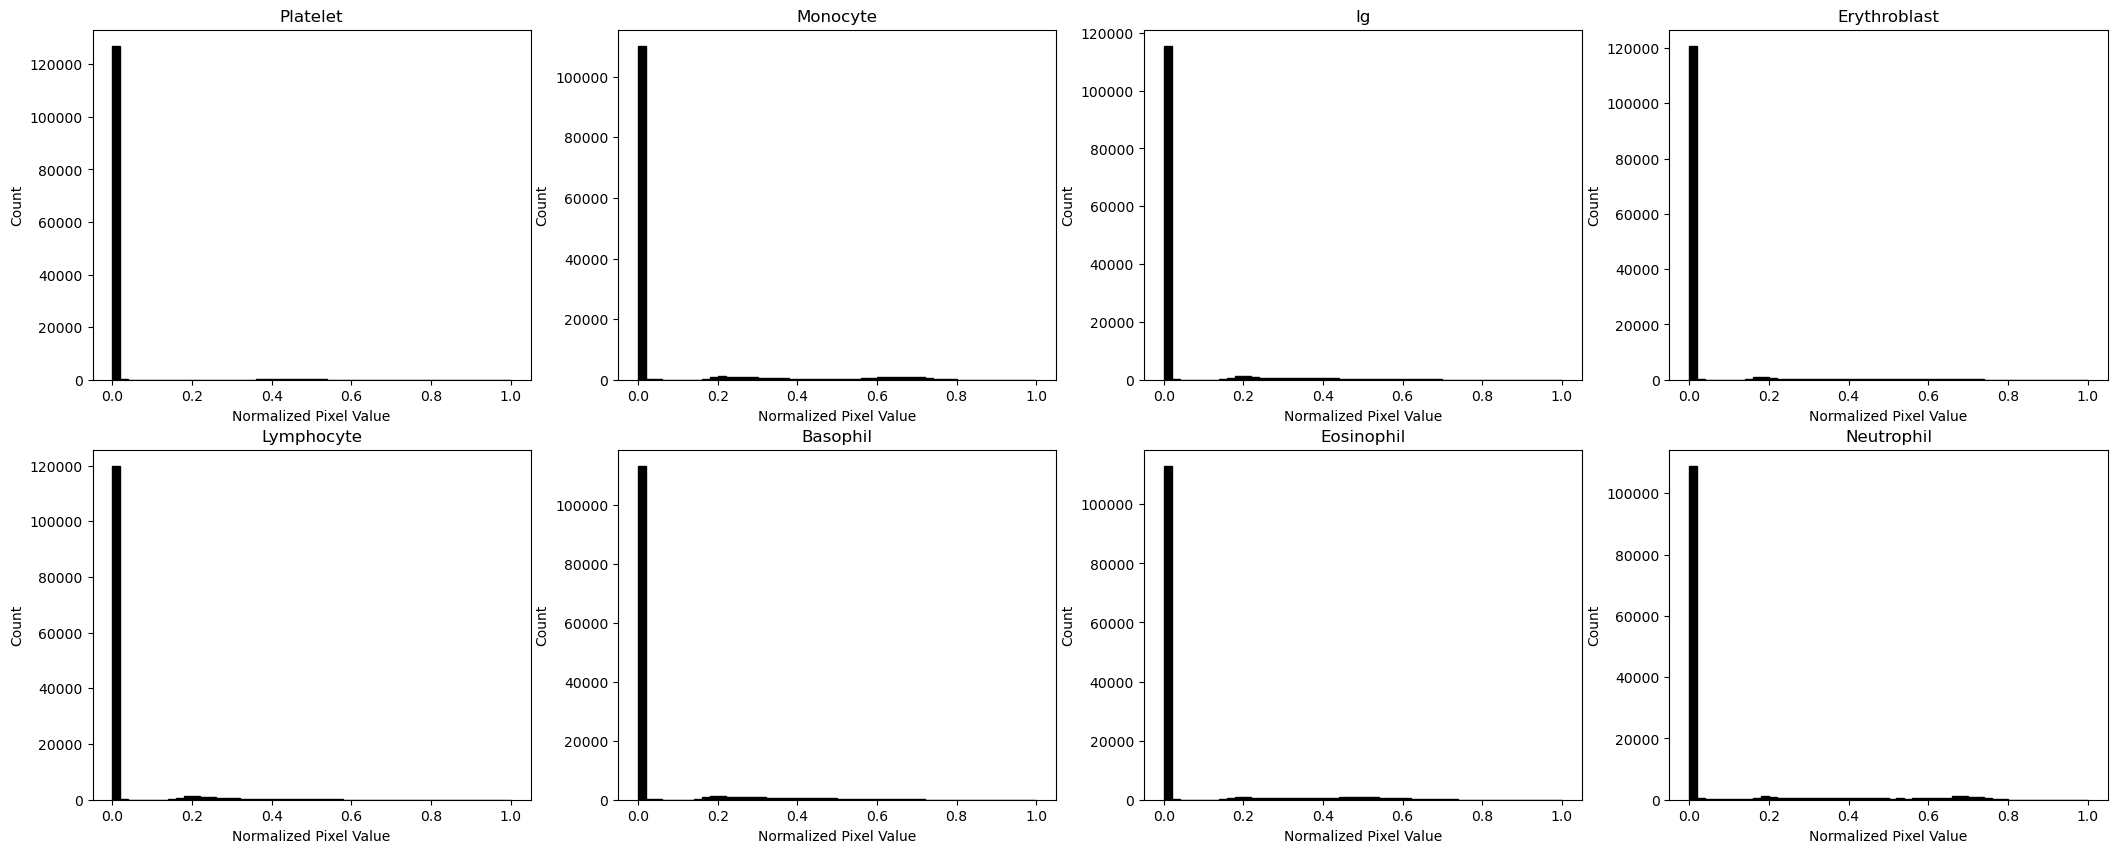

In [79]:
display_hist(normalize_pixel_vals(load_example_images()))

In [10]:
lum_feat_vectors = np.load('feat_vectors/train/lum_feat_vectors.npy')
lum_feat_vectors.shape

(20376, 50)

In [47]:
#Run PCA on all features to evaluate explained varianed for each component
lum_pca = PCA(svd_solver='randomized', whiten=True).fit(lum_feat_vectors)

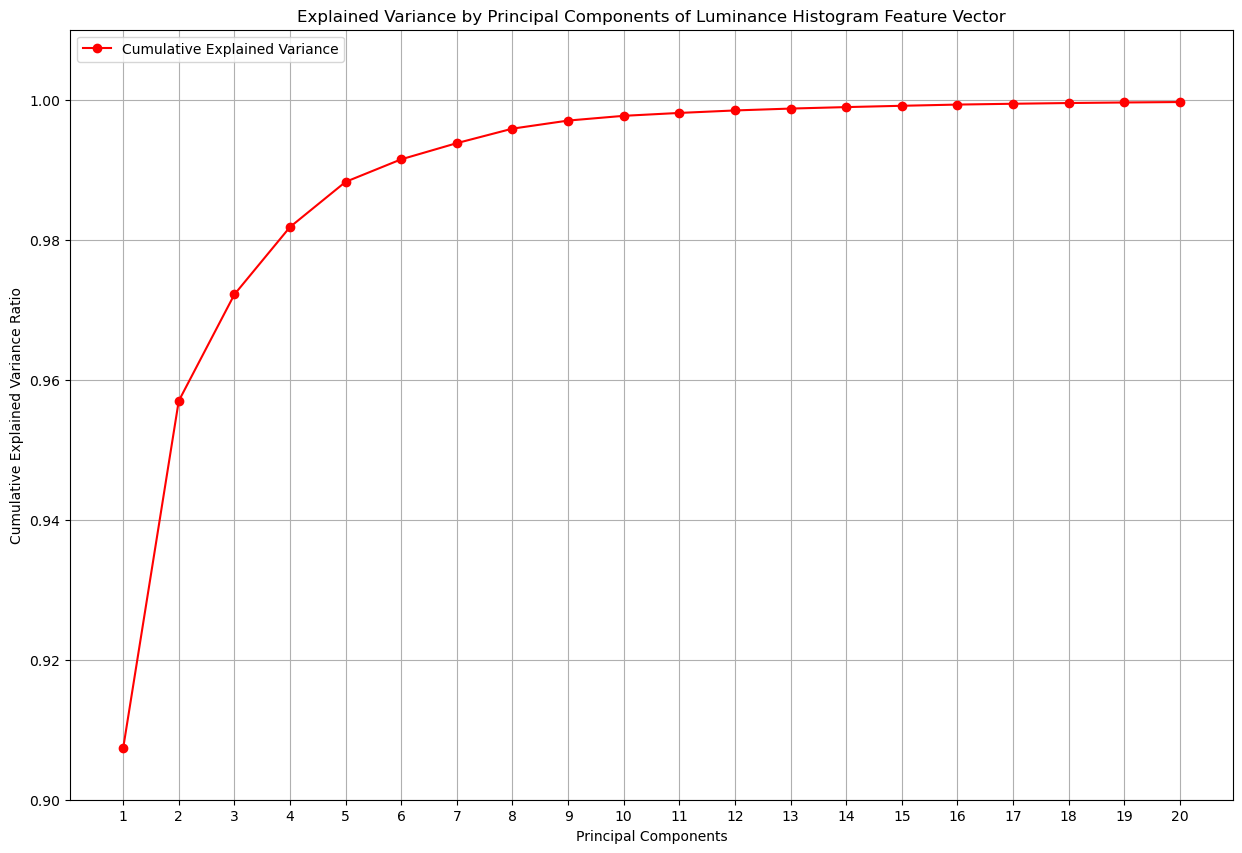

In [34]:
# Individual explained variance ratios
individual_variances = lum_pca.explained_variance_ratio_

# Compute the cumulative explained variance ratio
cumulative_variances = np.cumsum(individual_variances)

# Create the line plot for cumulative variance
plt.figure(figsize=(15,10))
line = plt.plot(range(1, 21), cumulative_variances[0:20], marker='o', linestyle='-', color='r', 
                label='Cumulative Explained Variance')

# for i, (cum_val) in enumerate(cumulative_variances[0:20]):
#     plt.text(i+1, cum_val, f'{cum_val*100:.1f}%', ha='right', va='bottom', rotation='vertical')


plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by Principal Components of Luminance Histogram Feature Vector')
plt.xticks(range(1, 21))
plt.legend(loc='upper left')
plt.ylim(0.90, 1.01) 
plt.grid(True)
plt.show()

In [13]:
#Choose top 5 principal components to acheive ~98% explained variance
lum_pca, lum_xpca = run_pca(lum_feat_vectors, 5)
lum_xpca.shape

(20376, 5)

In [36]:
#Randomly sample 4000 data points for tSNE evaluation
random_integers = np.random.randint(0, 20376, size=4000)
random_integers_list = random_integers.tolist()

sampled_rows = lum_xpca[random_integers_list]
sampled_labels = train_labels[random_integers_list]

In [37]:
lum_tsne = run_tsne(sampled_rows, 2, perplexity=30, learning_rate=400)

/home/ftitchenal/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


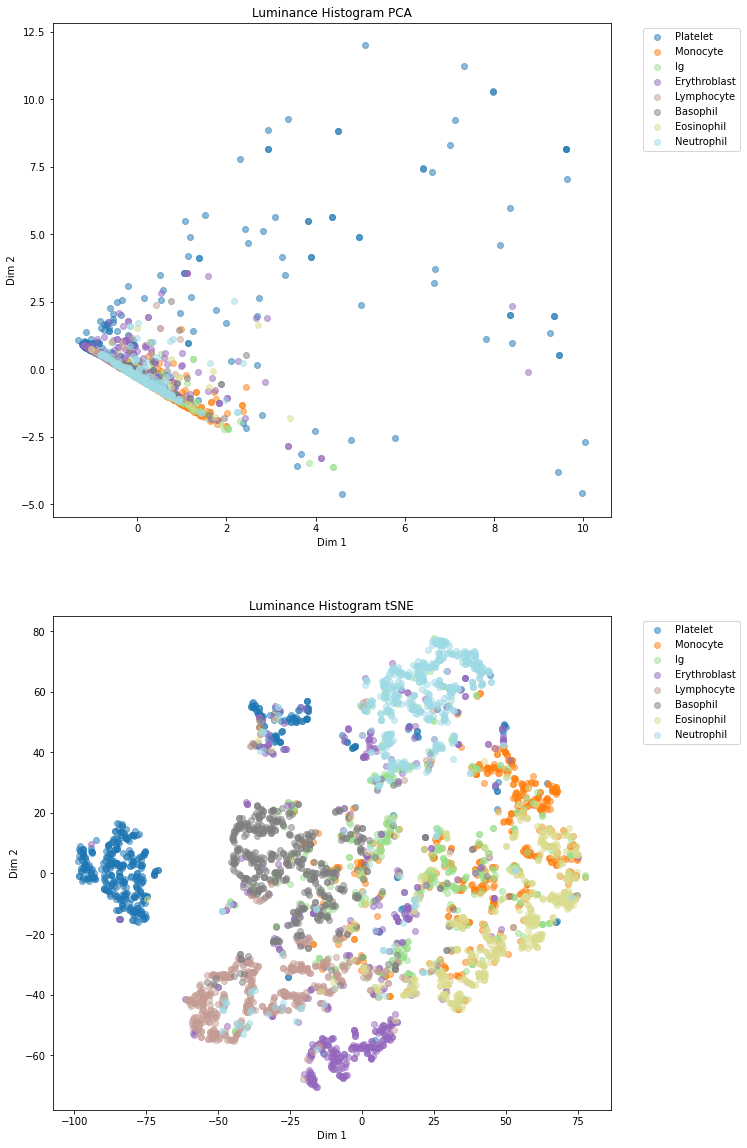

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,20))
plot_classes(sampled_rows, sampled_labels, ax[0], title='Luminance Histogram PCA')
plot_classes(lum_tsne, sampled_labels, ax[1], title='Luminance Histogram tSNE')

### HOG PCA

In [14]:
hog_feat_vector = np.load('feat_vectors/train/hog_feat_vects_compressed.npz')['a']
hog_feat_vector.shape

(20376, 900)

In [49]:
#Run PCA on all features to evaluate explained varianed for each component
hog_pca = PCA(n_components=300, svd_solver='randomized', whiten=True).fit(hog_feat_vector)

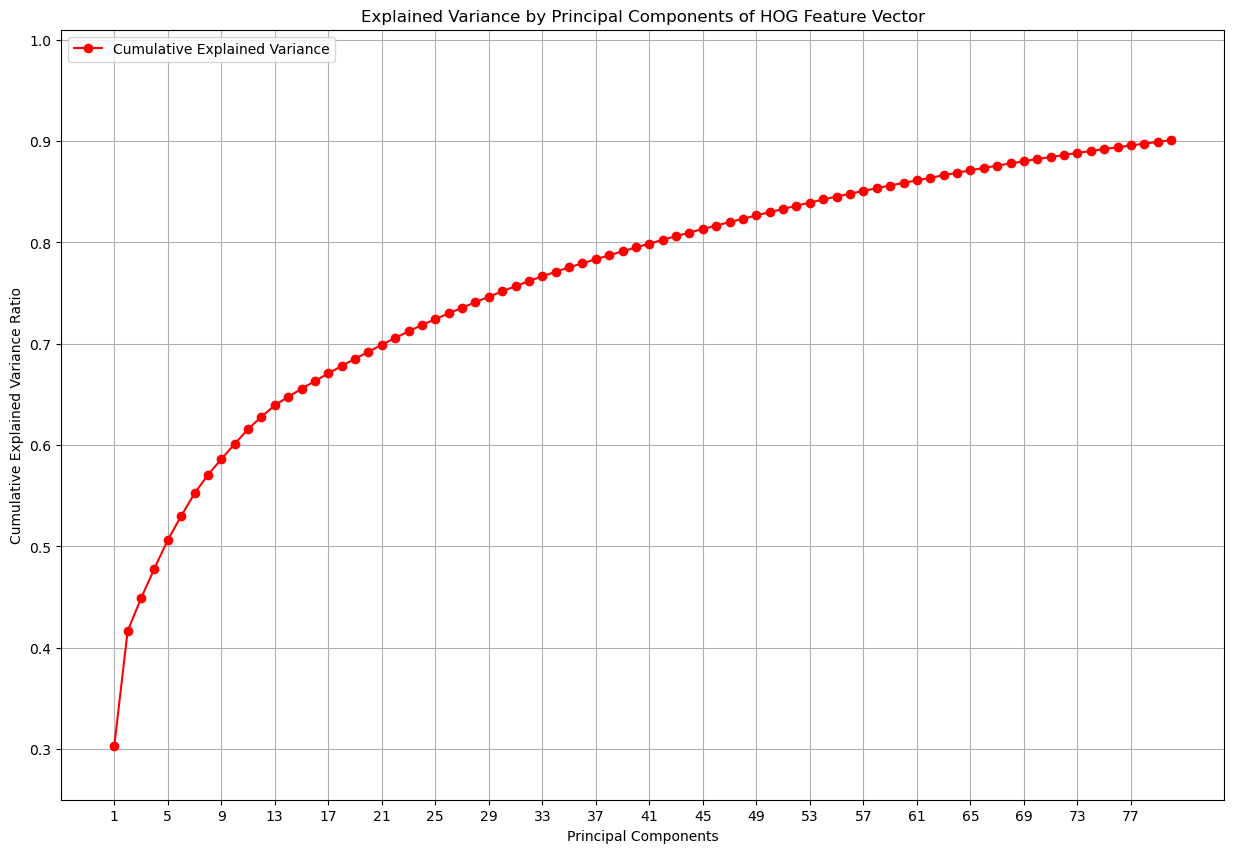

In [38]:
# Individual explained variance ratios
individual_variances = hog_pca.explained_variance_ratio_

# Compute the cumulative explained variance ratio
cumulative_variances = np.cumsum(individual_variances)

# Create the line plot for cumulative variance
plt.figure(figsize=(15,10))
line = plt.plot(range(1, 81), cumulative_variances[0:80], marker='o', linestyle='-', color='r', 
                label='Cumulative Explained Variance')

# for i, (cum_val) in enumerate(cumulative_variances[0:50]):
#     plt.text(i+1, cum_val, f'{cum_val*100:.1f}%', ha='right', va='bottom', rotation='horizontal')



plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title(f'Explained Variance by Principal Components of HOG Feature Vector')
plt.xticks(range(1, 81, 4))
plt.legend(loc='upper left')
plt.ylim(0.25, 1.01) 
plt.grid(True)
plt.show()

In [15]:
#Choose top 77 principal components to acheive ~90% explained variance
hog_pca, hog_xpca = run_pca(hog_feat_vector, 77)
hog_xpca.shape

(20376, 77)

In [43]:
#Randomly sample 4000 data points for tSNE evaluation
sampled_rows = hog_xpca[random_integers_list]

In [69]:
hog_tsne = run_tsne(sampled_rows, 2, perplexity=30, learning_rate=10)

/home/ftitchenal/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


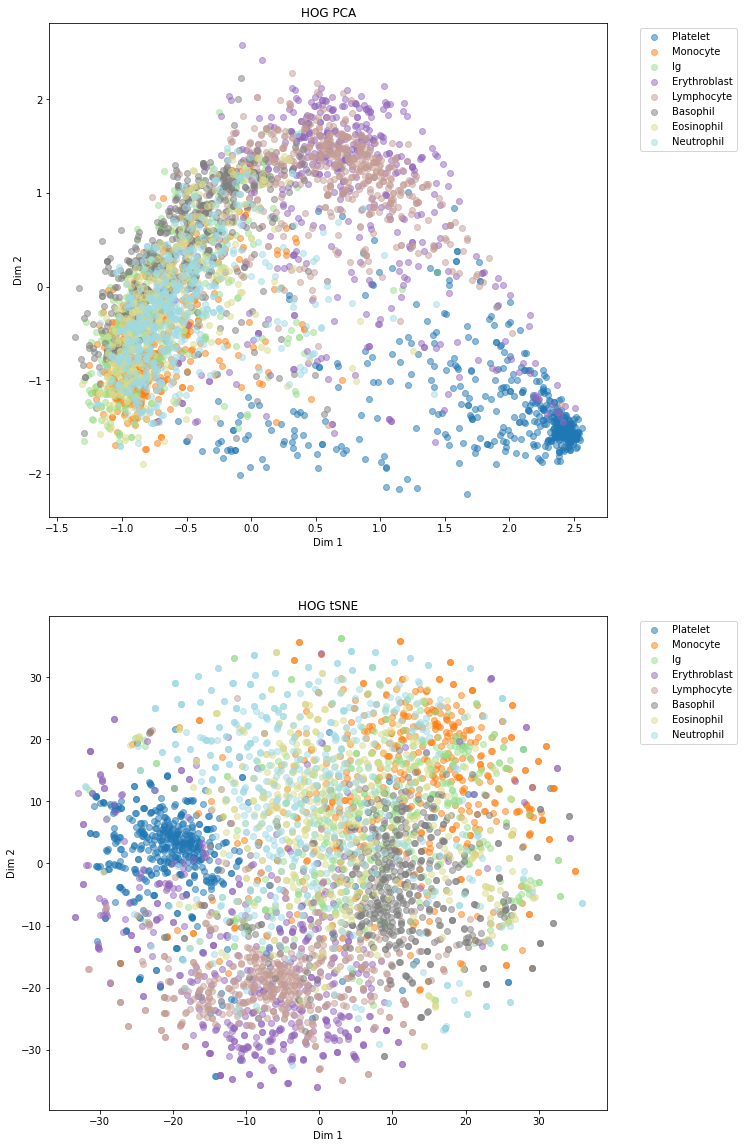

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,20))
plot_classes(sampled_rows, sampled_labels, ax[0], title='HOG PCA')
plot_classes(hog_tsne, sampled_labels, ax[1], title='HOG tSNE')

In [51]:
hog_tsne_3d = run_tsne(hog_xpca_reduced, 3)

/home/ftitchenal/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ftitchenal/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 0.92, '3D Projection HOG tSNE')

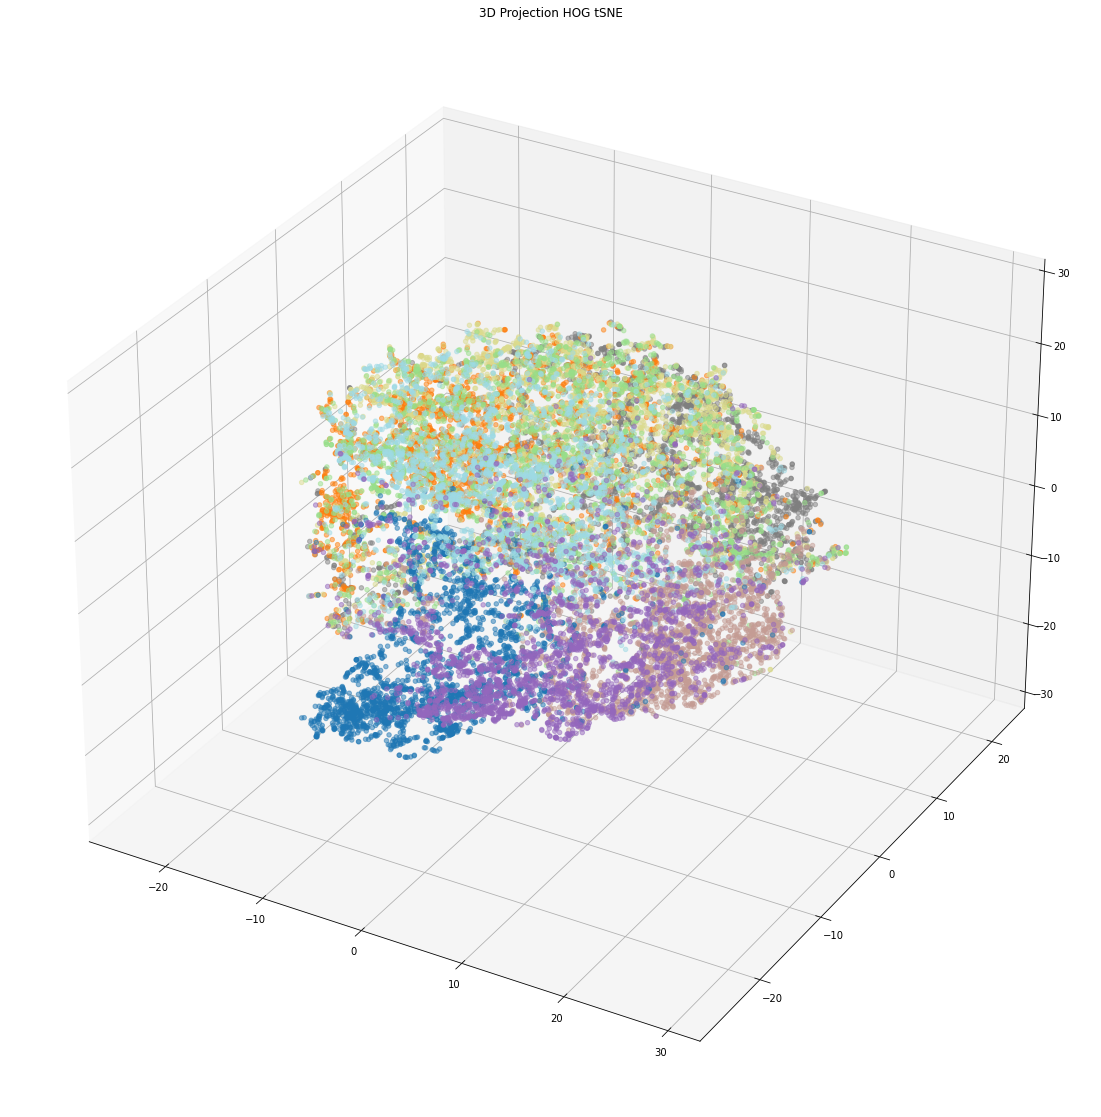

In [52]:
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(projection='3d')

colormap = plt.cm.tab20
colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(train_labels)))]

# project the features into 2 dimensions
for k in range(len(np.unique(train_labels))):
    ax.scatter(hog_tsne_3d[train_labels==k, 0], hog_tsne_3d[train_labels==k, 1], hog_tsne_3d[train_labels==k, 2], alpha=0.5, facecolors=colorst[k])

ax.set_title('3D Projection HOG tSNE')

### Scale-Invariant Feature Transform (SIFT)

In [71]:
def sift_features(imgs):

    #Convert image arrays to integers for SIFT algorithm
    imgs = imgs.astype('uint8')

    out_imgs = np.ndarray((360,360,3,8))

    for i in range(imgs.shape[2]):
        img = imgs[:,:,i].astype('uint8')

        # Create a SIFT object
        sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=10, sigma=1.6)

        # Detect and draw keypoints
        key_points, descriptors = sift.detectAndCompute(img, None)
        img = cv2.drawKeypoints(img,kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        out_imgs[:,:,:,i] = img

    return out_imgs

In [ ]:
# Create a SIFT object
sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=10, sigma=1.6)

# Detect and draw keypoints
kp, descriptors = sift.detectAndCompute(ex_imgs[:,:,7].astype('uint8'), None)
img = cv2.drawKeypoints(ex_imgs[:,:,7].astype('uint8'),kp, ex_imgs[:,:,7].astype('uint8'), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show image with keypoints
plt.imshow(img)


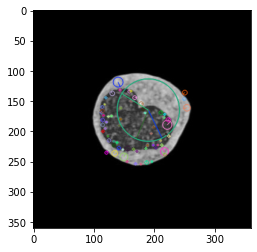

In [165]:
# Create a SIFT object
sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=10, sigma=1.6)

# Detect and draw keypoints
kp, descriptors = sift.detectAndCompute(ex_imgs[:,:,1].astype('uint8'), None)
img = cv2.drawKeypoints(ex_imgs[:,:,1].astype('uint8'),kp, ex_imgs[:,:,1].astype('uint8'), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show image with keypoints
plt.imshow(img)

### ResNet50 Feature Vector

In [16]:
#Run get_ft_vects.py to extract feat vectors

res_feat_vector = np.load('/home/ftitchenal/DATASCI_281/281-final-project/noteboooks/feat_vectors/train/res_feat_vectors.npy')
res_feat_vector = res_feat_vector.reshape((20376, 2048))

In [51]:
#Run PCA on all features to evaluate explained variance for each component
resnet_pca = PCA(n_components = 300, svd_solver='randomized', whiten=True).fit(res_feat_vector)

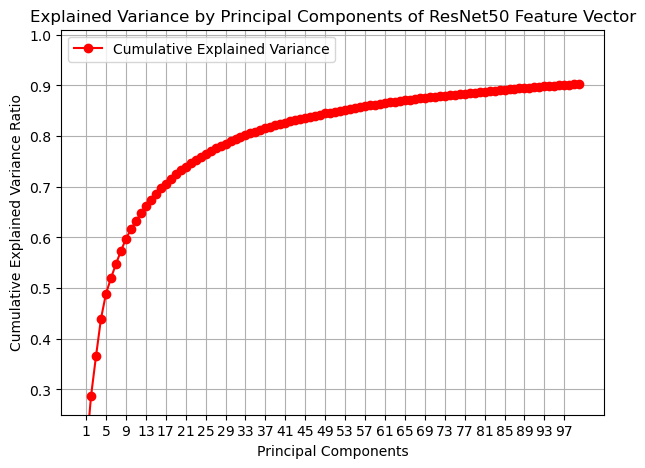

In [42]:
# Individual explained variance ratios
individual_variances = resnet_pca.explained_variance_ratio_

# Compute the cumulative explained variance ratio
cumulative_variances = np.cumsum(individual_variances)

# Create the line plot for cumulative variance
plt.figure(figsize=(7,5))
line = plt.plot(range(1, 101), cumulative_variances[0:100], marker='o', linestyle='-', color='r', 
                label='Cumulative Explained Variance')

# for i, (cum_val) in enumerate(cumulative_variances[0:50]):
#     plt.text(i+1, cum_val, f'{cum_val*100:.1f}%', ha='right', va='bottom', rotation='horizontal')



plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title(f'Explained Variance by Principal Components of ResNet50 Feature Vector')
plt.xticks(range(1, 101, 4))
plt.legend(loc='upper left')
plt.ylim(0.25, 1.01) 
plt.grid(True)
plt.show()

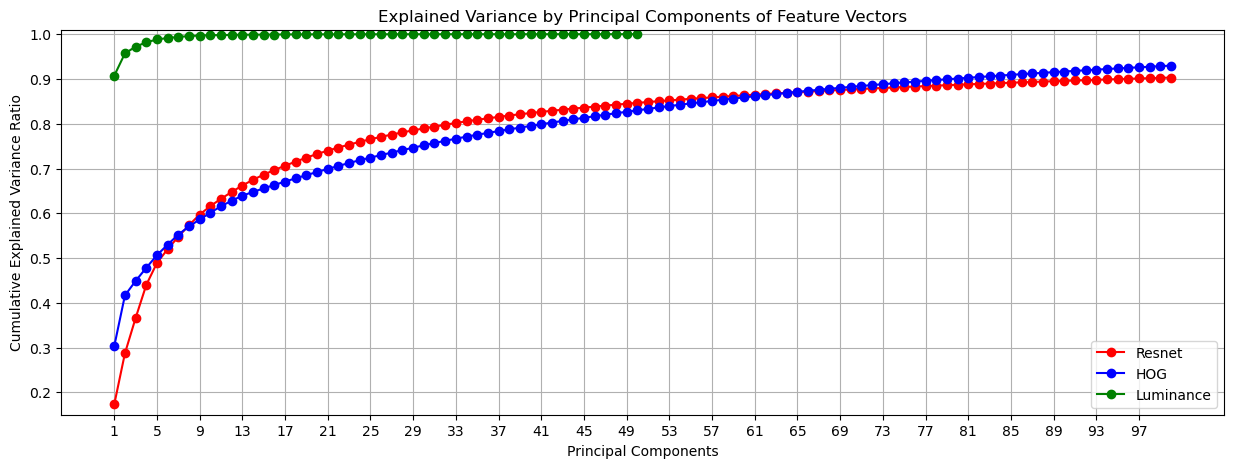

In [58]:
# Individual explained variance ratios
lum_individual_variances = lum_pca.explained_variance_ratio_
hog_individual_variances = hog_pca.explained_variance_ratio_
individual_variances_resnet = resnet_pca.explained_variance_ratio_

# Compute the cumulative explained variance ratio
lum_cumulative_variances = np.cumsum(lum_individual_variances)
hog_cumulative_variances = np.cumsum(hog_individual_variances)
cumulative_variances_resnet = np.cumsum(individual_variances_resnet)

# Create the line plot for cumulative variance
plt.figure(figsize=(15,5))
line = plt.plot(range(1, 101), cumulative_variances_resnet[0:100], marker='o', linestyle='-', color='r', 
                label='Resnet')
line = plt.plot(range(1, 101), hog_cumulative_variances[0:100], marker='o', linestyle='-', color='b', 
                label='HOG')
line = plt.plot(range(1, 51), lum_cumulative_variances[0:50], marker='o', linestyle='-', color='g', 
                label='Luminance')




plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title(f'Explained Variance by Principal Components of Feature Vectors')
plt.xticks(range(1, 101, 4))
plt.legend(loc='lower right')
plt.ylim(0.15, 1.01) 
plt.grid(True)
plt.show()

In [17]:
#Choose 93 principal components to acheive ~90% explained variance
resnet_pca, resnet_xpca = run_pca(res_feat_vector, 93)
resnet_xpca.shape

(20376, 93)

In [82]:
#Randomly sample 4000 data points for tSNE evaluation
sampled_rows = resnet_xpca[random_integers_list]

In [117]:
resnet_tsne = run_tsne(sampled_rows, 2, perplexity=10, learning_rate=1000)

/home/ftitchenal/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


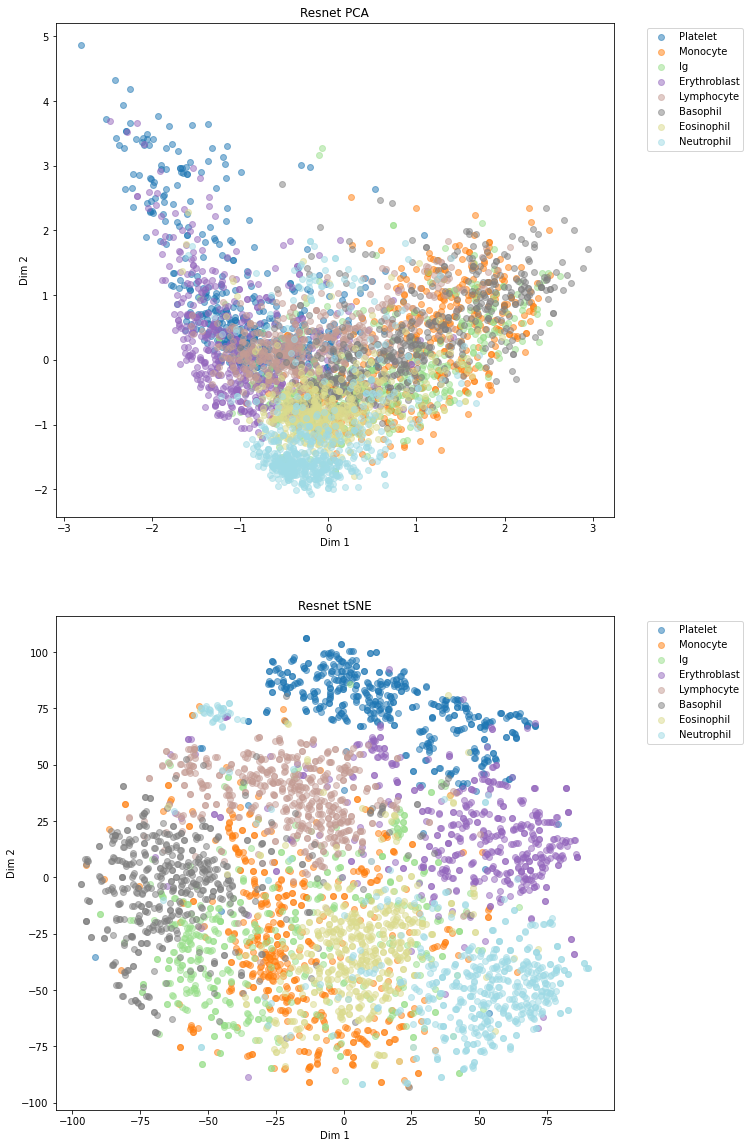

In [118]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,20))
plot_classes(sampled_rows, sampled_labels, ax[0], title='Resnet PCA')
plot_classes(resnet_tsne, sampled_labels, ax[1], title='Resnet tSNE')

### Model Building

#### Model 1: Logistic Regression with Luminance Histogram and HOG feature vector

In [44]:
print(hog_xpca.shape)
print(lum_xpca.shape)

(20376, 77)
(20376, 5)


In [45]:
#Concatenate Luminance and HOG feature vectors
lum_hog_feat_vect = np.hstack((hog_xpca, lum_xpca))
print(lum_hog_feat_vect.shape)
print(train_labels.shape)

(20376, 82)
(20376,)


In [46]:
#Randomly shuffle training data
shuffled_indices = np.random.permutation(len(lum_hog_feat_vect))
X_train = lum_hog_feat_vect[shuffled_indices]
y_train = train_labels[shuffled_indices]
print(X_train.shape)
print(y_train.shape)

(20376, 82)
(20376,)


In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

num_classes = 8

# Define the logistic regression model
model_1 = Sequential()
model_1.add(Dense(num_classes, input_dim=X_train.shape[1], activation='softmax'))  
model_1.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        'accuracy'
    ],
)

# Train the model
history_model_1 = model_1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the model
loss, accuracy = model_1.evaluate(X_train, y_train)
print(f"Loss: {loss}, Accuracy: {accuracy}")

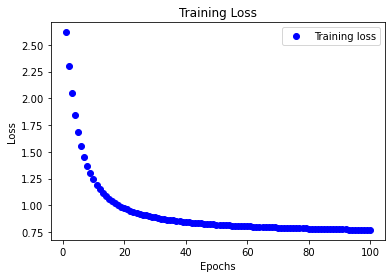

In [123]:
train_loss = history_model_1.history['loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


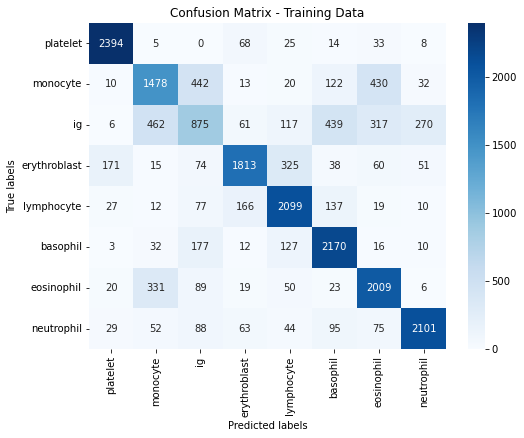

In [124]:
# Generate predictions
y_pred = np.argmax(model_1.predict(X_train), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(TRAIN_DIR), yticklabels=os.listdir(TRAIN_DIR))

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Training Data')
plt.show()

#### Model 1 Validation

In [23]:
#Load luminance feat vector for validation set
val_lum_feat_vector = np.load('feat_vectors/val/lum_feat_vectors.npy')
val_lum_feat_vector.shape

(1456, 50)

In [24]:
#Transform based on train pca
val_lum_X_pca = lum_pca.transform(val_lum_feat_vector)
val_lum_X_pca.shape

(1456, 5)

In [25]:
#Load HOG feat vector for validation set
val_hog_feat_vector = np.load('feat_vectors/val/hog_feat_vects_compressed.npz')['a']
val_hog_feat_vector.shape

(1456, 900)

In [26]:
#Transform based on train pca
val_hog_X_pca = hog_pca.transform(val_hog_feat_vector)
val_hog_X_pca.shape

(1456, 77)

In [87]:
#Concatenate Luminance and HOG feature vectors 

lum_hog_val_feat_vect = np.hstack((val_hog_X_pca, val_lum_X_pca))
lum_hog_val_feat_vect.shape

(1456, 82)

In [88]:
#Randomly shuffle validation data
shuffled_indices = np.random.permutation(len(lum_hog_val_feat_vect))
X_val = lum_hog_val_feat_vect[shuffled_indices]
y_val = val_labels[shuffled_indices]
print(X_val.shape)
print(y_val.shape)

(1456, 82)
(1456,)


 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


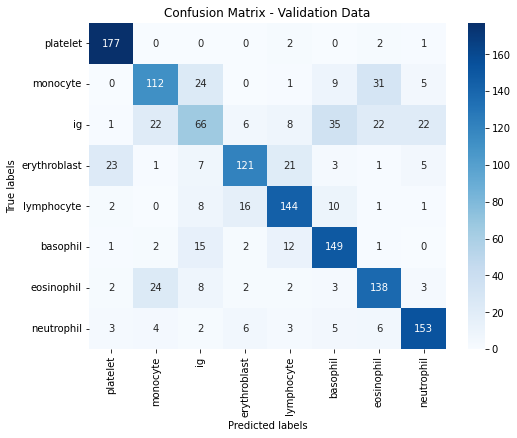

In [131]:
# Generate predictions
y_val_pred = np.argmax(model_1.predict(X_val), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(VAL_DIR), yticklabels=os.listdir(VAL_DIR))

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Validation Data')
plt.show()

In [132]:
# Evaluate the model
loss, accuracy = model_1.evaluate(X_val, y_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7223 - loss: 0.7905
Loss: 0.7718724608421326, Accuracy: 0.7280219793319702


#### Model 2: Logistic Regression with Luminance Histogram, HOG, and RestNe50 feature vector

In [32]:
print(hog_xpca.shape)
print(lum_xpca.shape)
print(resnet_xpca.shape)

(20376, 77)
(20376, 5)
(20376, 93)


In [18]:
#Concatenate Luminance, HOG, and ResNet feature vectors 
#Save full feature vector

full_feat_vect = np.hstack((hog_xpca, lum_xpca, resnet_xpca))
np.save('feat_vectors/train/full_feat_vectors', full_feat_vect)

In [19]:
#Randomly shuffle training data
shuffled_indices = np.random.permutation(len(full_feat_vect))
X_train = full_feat_vect[shuffled_indices]
y_train = train_labels[shuffled_indices]
print(X_train.shape)
print(y_train.shape)

(20376, 175)
(20376,)


In [18]:
def create_model(hp):
    # Define exponential decay lr schedule 
    initial_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    decay_steps = hp.Choice('decay_steps', values=[2500, 5000, 7500])
    decay_rate = hp.Choice('decay_rate', values=[0.6, 0.7, 0.8])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(  
                                                                initial_learning_rate=initial_learning_rate,
                                                                decay_steps=decay_steps,
                                                                decay_rate=decay_rate
                                                            )
    # Define the logistic regression model
    model_2 = Sequential()
    model_2.add(Dense(8, input_dim=X_train.shape[1], activation='softmax')) #Softmax function for multi-class classificaiton
    model_2.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
        loss=keras.losses.SparseCategoricalCrossentropy(), #Use sparse cross-entropy since labels are integers 
        metrics=[
            'accuracy'
        ],
    )
    return model_2

In [19]:
#Define Random Search hyperparameter tuner 
tuner = kt.RandomSearch(create_model,
                                objective='val_accuracy',
                                max_trials=10,
                                seed=1)

2024-04-18 20:31:45.226733: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [31]:
#Perform hyperparameter search on train data
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Trial 10 Complete [00h 04m 52s]
val_accuracy: 0.7596153616905212

Best val_accuracy So Far: 0.7596153616905212
Total elapsed time: 00h 47m 40s


In [32]:
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')}. 
The optimal decay steps is {best_hps.get('decay_steps')}. 
The optimal decay rate is {best_hps.get('decay_rate')}.
""")


The optimal learning rate is 0.01. 
The optimal decay steps is 5000. 
The optimal decay rate is 0.7.



In [33]:
model_2 = tuner.hypermodel.build(best_hps)

In [37]:
# Train the model
model_2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the model
loss, accuracy = model_2.evaluate(X_train, y_train)
print(f"Loss: {loss}, Accuracy: {accuracy}")

637/637 [==============================] - 3s 5ms/step - loss: 0.2152 - accuracy: 0.9297
Loss: 0.21522033214569092, Accuracy: 0.9296721816062927


In [26]:
def display_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

637/637 [==============================] - 4s 6ms/step


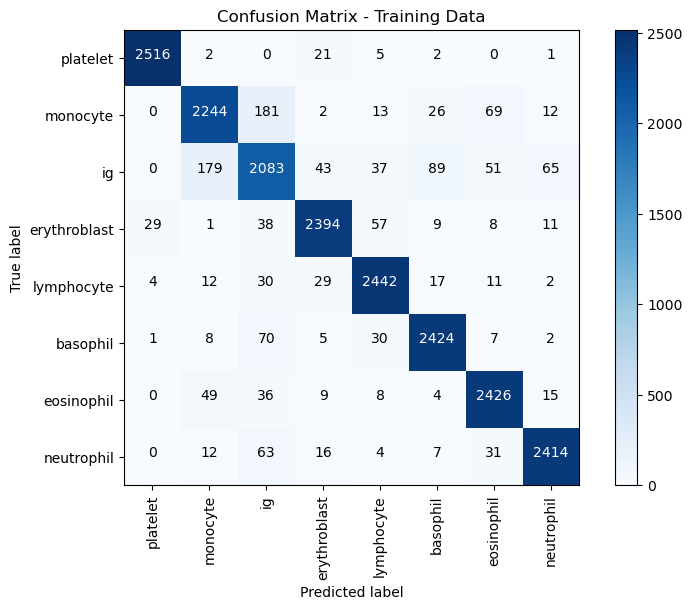

In [39]:
# Generate predictions
y_pred = np.argmax(model_2.predict(X_train), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Plot confusion matrix
display_confusion_matrix(conf_matrix, os.listdir(TRAIN_DIR),"Confusion Matrix - Training Data")

### Model 2 Validation

In [28]:
#Load ResNet50 feat vector for validation set
val_resnet_feat_vector = np.load('feat_vectors/val/res_feat_vectors.npy')
val_resnet_feat_vector = val_resnet_feat_vector.reshape((1456, 2048))
val_resnet_feat_vector.shape

(1456, 2048)

In [29]:
#Transform based on train pca
val_res_X_pca = resnet_pca.transform(val_resnet_feat_vector)
val_res_X_pca.shape

(1456, 93)

In [30]:
#Concatenate Luminance, HOG, and ResNet feature vectors 
#Save full validation feature vector

full_val_feat_vect = np.hstack((val_hog_X_pca, val_lum_X_pca, val_res_X_pca))
np.save('feat_vectors/val/full_val_feat_vectors', full_val_feat_vect)
full_val_feat_vect.shape

NameError: name 'val_hog_X_pca' is not defined

In [43]:
#Randomly shuffle validation data
shuffled_indices = np.random.permutation(len(full_val_feat_vect))
X_val = full_val_feat_vect[shuffled_indices]
y_val = val_labels[shuffled_indices]
print(X_val.shape)
print(y_val.shape)

(1456, 175)
(1456,)


46/46 [==============================] - 0s 7ms/step


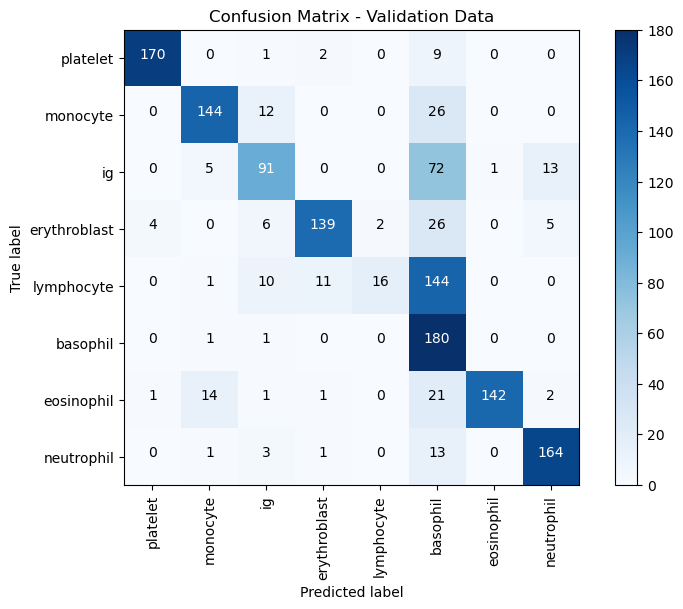

In [44]:
# Generate predictions
y_val_pred = np.argmax(model_2.predict(X_val), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
display_confusion_matrix(conf_matrix, os.listdir(VAL_DIR),"Confusion Matrix - Validation Data")

In [45]:
# Evaluate the model
loss, accuracy = model_2.evaluate(X_val, y_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

46/46 [==============================] - 0s 8ms/step - loss: 0.8605 - accuracy: 0.7184
Loss: 0.860523521900177, Accuracy: 0.718406617641449


### Model 2: Testing

In [31]:
#Load feat vectors for test set
test_lum_feat_vector = np.load('feat_vectors/test/lum_feat_vectors.npy')
print(test_lum_feat_vector.shape)

test_hog_feat_vector = np.load('feat_vectors/test/hog_feat_vects_compressed.npz')['a']
print(test_hog_feat_vector.shape)

test_resnet_feat_vector = np.load('feat_vectors/test/res_feat_vectors.npy')
test_resnet_feat_vector = test_resnet_feat_vector.reshape((1464, 2048))
print(test_resnet_feat_vector.shape)

(1464, 50)
(1464, 900)
(1464, 2048)


In [32]:
#Transform based on train pca
test_lum_X_pca = lum_pca.transform(test_lum_feat_vector)
print(test_lum_X_pca.shape)

test_hog_X_pca = hog_pca.transform(test_hog_feat_vector)
print(test_hog_X_pca.shape)

test_resnet_X_pca = resnet_pca.transform(test_resnet_feat_vector)
print(test_resnet_X_pca.shape)

(1464, 5)
(1464, 77)
(1464, 93)


In [33]:
#Concatenate feature vectors 

full_test_feat_vect = np.hstack((test_hog_X_pca, test_lum_X_pca, test_resnet_X_pca))
np.save('feat_vectors/test/full_test_feat_vectors', full_test_feat_vect)
full_test_feat_vect.shape

(1464, 175)

In [34]:
#Randomly shuffle validation data
shuffled_indices = np.random.permutation(len(full_test_feat_vect))
X_test = full_test_feat_vect[shuffled_indices]
y_test = test_labels[shuffled_indices]
print(X_test.shape)
print(y_test.shape)

(1464, 175)
(1464,)


 1/46 [..............................] - ETA: 2s

46/46 [==============================] - 0s 7ms/step


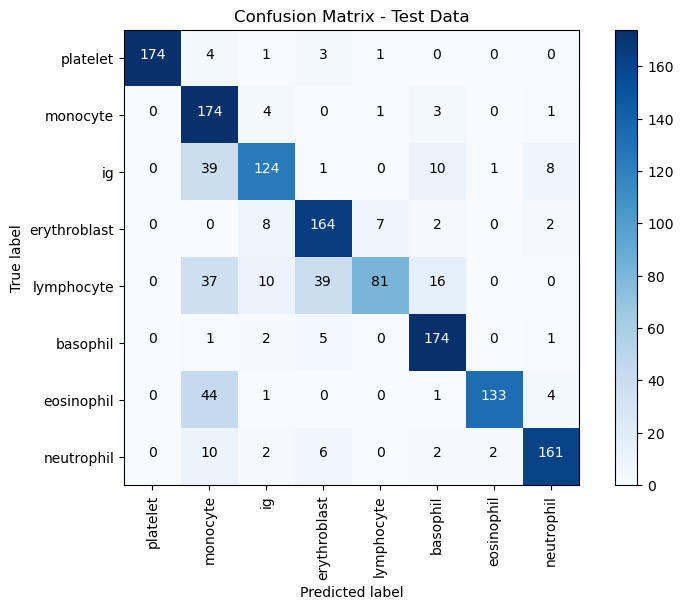

In [50]:
# Generate predictions
y_test_pred = np.argmax(model_2.predict(X_test), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
display_confusion_matrix(conf_matrix, os.listdir(TEST_DIR),"Confusion Matrix - Test Data")

In [51]:
# Evaluate the model
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

46/46 [==============================] - 1s 11ms/step - loss: 0.5635 - accuracy: 0.8094
Loss: 0.5634770393371582, Accuracy: 0.8094262480735779


### Model 3: Random Forest with Luminance, HOG, and ResNet

In [53]:
# Define the random forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

In [54]:
# Train the model with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200)

In [55]:
train_accuracy = best_rf_classifier.score(X_train, y_train)
print("Accuracy:", train_accuracy)

Accuracy: 0.9385060855908912


In [66]:
y_pred = best_rf_classifier.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred)

In [67]:
def display_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

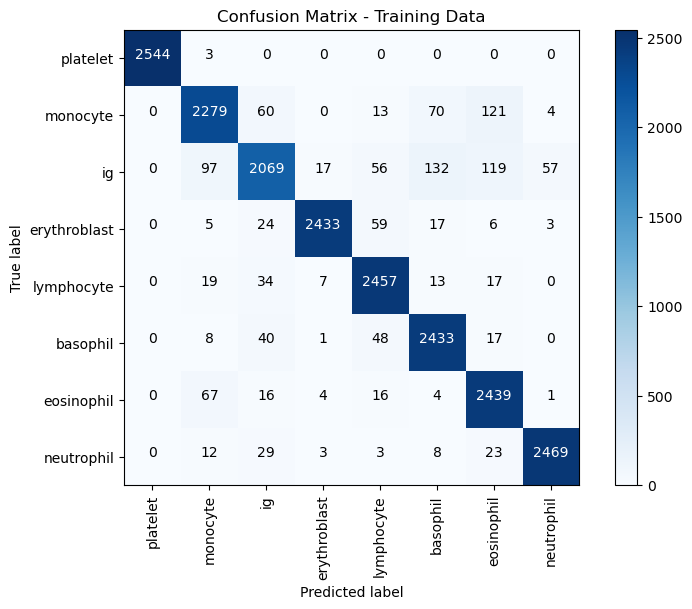

In [68]:
display_confusion_matrix(conf_matrix, os.listdir(TRAIN_DIR), title='Confusion Matrix - Training Data')

### Model 3: Validation

In [145]:
val_accuracy = best_rf_classifier.score(X_val, y_val)
print("Accuracy:", val_accuracy)

Accuracy: 0.7857142857142857


In [147]:
y_val_pred = best_rf_classifier.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_val_pred)

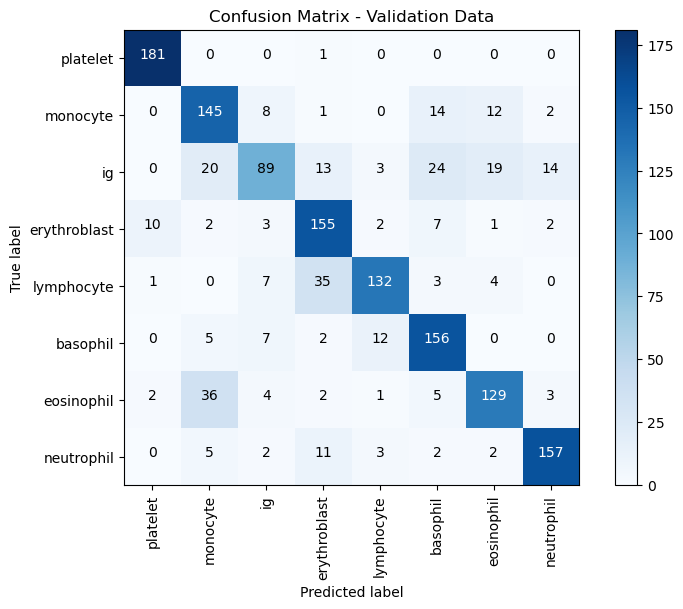

In [148]:
display_confusion_matrix(conf_matrix, os.listdir(TRAIN_DIR), title='Confusion Matrix - Validation Data')

### Model 3 Testing

In [211]:
test_accuracy = best_rf_classifier.score(X_test, y_test)
print("Accuracy:", test_accuracy)

Accuracy: 0.8066939890710383


In [212]:
y_test_pred = best_rf_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)

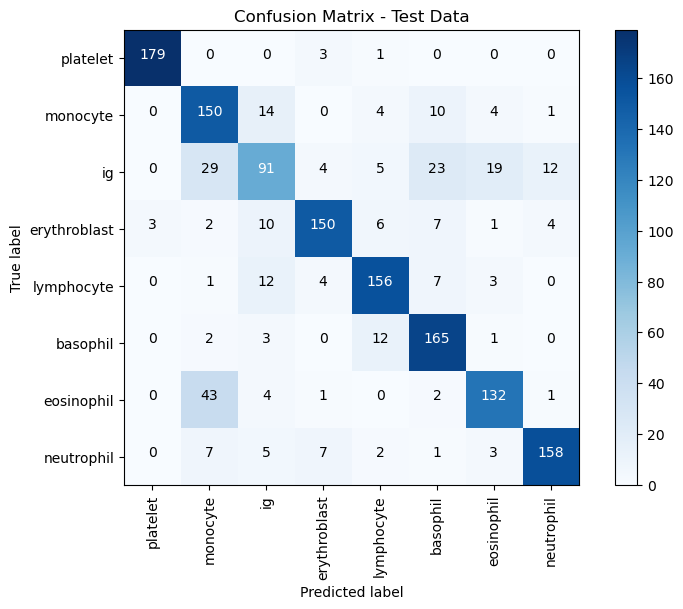

In [213]:
display_confusion_matrix(conf_matrix, os.listdir(TEST_DIR), title='Confusion Matrix - Test Data')